# NAIRU Model

Modelling the non-accelerating inflation rate of unemployment for the Australian economy.

## Acknowledgements

This work has drawn on ideas and approaches in the following:

https://www.rba.gov.au/publications/bulletin/2017/jun/pdf/bu-0617-2-estimating-the-nairu-and-the-unemployment-gap.pdf

https://treasury.gov.au/sites/default/files/2021-04/p2021-164397_estimatingthenairuinaustralia.pdf

https://www.rba.gov.au/education/resources/explainers/pdf/nairu.pdf?v=2024-05-09-14-09-00

https://github.com/MacroDave/NAIRU

https://gross.substack.com/p/navigating-the-nairu?utm_source=publication-search

https://www.rbnz.govt.nz/-/media/project/sites/rbnz/files/publications/analytical-notes/2018/an2018-04.pdf

https://cmr.uni-koeln.de/fileadmin/wiso_fak/cmr/pdf/Berger_Publication_list/nairu.pdf

## Python set-up

In [1]:
# Analtic imports
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt

In [2]:
# local imports
from abs_data_capture import (
    get_abs_series, 
)
from rba_data_capture import (
    get_data,
)
import plotting

In [3]:
# Plotting set-up
plt.style.use("fivethirtyeight")
CHART_DIR = "./CHARTS/NAIRU/"
plotting.set_chart_dir(CHART_DIR)
plotting.clear_chart_dir(CHART_DIR)

# display charts in this notebook
SHOW = True

## Data capture

#### Utility

In [4]:
def monthly_to_quarterly(data: pd.Series) -> pd.Series:
    """Convert monthly data to quarterly data by taking the mean of 
    the three months in each quarter. Ignore quarters with less than 
    three months data. Drop NA items."""

    return (
        data
        .groupby(pd.PeriodIndex(data.index, freq="Q"))
        .agg(['mean', 'count'])
        .apply(lambda x: x['mean'] if x['count'] == 3 else np.nan, axis=1)
        .dropna()
    )


#### Unemployment rate (from ABS 1364, 6202)

A little unexpected: We need to fake up a zip file
Historic data ranges over:  1959Q3 2023Q4


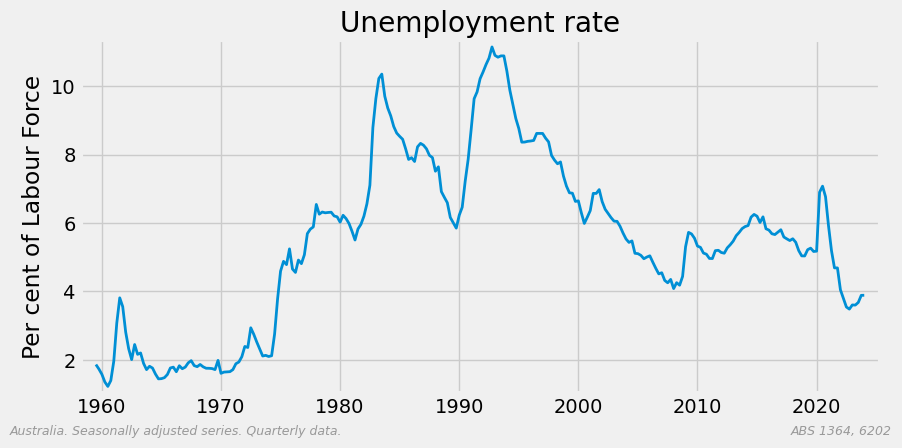

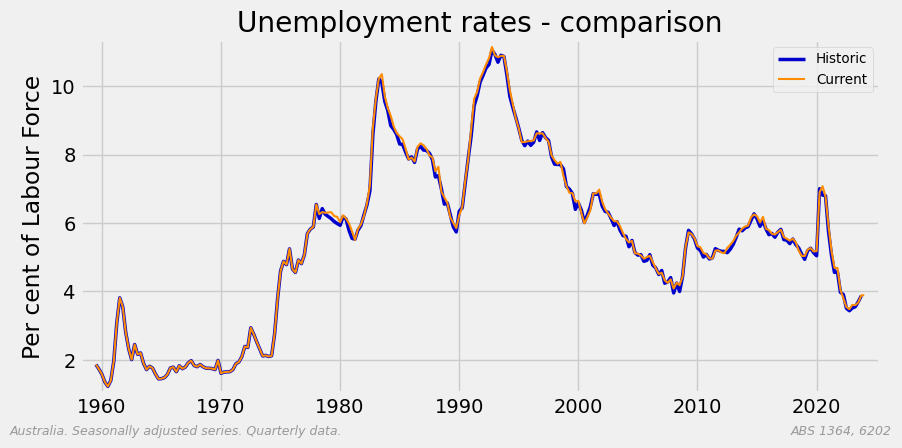

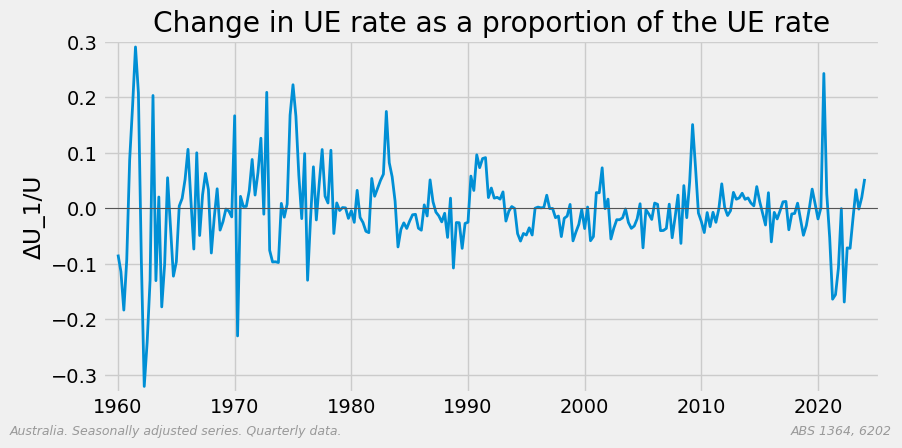

In [5]:

def get_u() -> tuple[pd.Series, pd.Series, pd.Series]:
    """Get the unemployment related data from the ABS and
    calculate the UE rate, and the change in the UE rate
    as a proportion of the UE rate."""

    # get historic unemployment - quarterly data
    old_meta, old = get_abs_series(cat_id="1364.0.15.003", series_ids=["A2454521V", "A2454517C"])
    uemployed, labour_force = old['A2454521V'], old['A2454517C']
    ue_hist = ((uemployed / labour_force) * 100).dropna()
    print('Historic data ranges over: ', ue_hist.index[0], ue_hist.index[-1])

    # get the latest unemployment rate - monthly data - convert to quarterly
    lfs_meta, lfs = get_abs_series(cat_id="6202.0", series_ids=["A84423043C", "A84423047L"])
    employed, labour_force2 = lfs["A84423043C"], lfs["A84423047L"]  
    ue_rate_m = ((1 - employed / labour_force2) * 100).dropna()
    ue_rate_q = monthly_to_quarterly(ue_rate_m)

    # combine into a single quarterly unemployment rate series
    u = (
        ue_rate_q
        .reindex(pd.period_range(start=ue_hist.index.min(), end=ue_rate_q.index.max()))
        .sort_index()
        .pipe(lambda x: x.where(x.notnull(), ue_hist))
    )
    
    # calculate the change in the UE rate as a proportion of the UE rate
    delta_U = (u.shift(1) - u.shift(2)) / u

    # Plot the data
    common_format = {
        'lfooter': "Australia. Seasonally adjusted series. Quarterly data. ",
        'rfooter': "ABS 1364, 6202",
        'show': SHOW,
        'y0': True,
    }

    ax = u.plot(lw=2)
    plotting.finalise_plot(
        ax,
        title="Unemployment rate",
        ylabel="Per cent of Labour Force",
        **common_format,
    )

    # There are small differences between the two series ...
    plotting.line_plot(
        pd.DataFrame({'Historic': ue_hist, 'Current': u}),
        title="Unemployment rates - comparison",
        ylabel="Per cent of Labour Force",
        width=[2.5, 1.5],
        **common_format,
    )

    ax = delta_U.plot(lw=2)
    plotting.finalise_plot(
        ax,
        title="Change in UE rate as a proportion of the UE rate",
        ylabel="ΔU_1/U",
        **common_format,
    )

    # return the values
    return u, delta_U


U, ΔU_1_over_U = get_u()

#### Inflation (from ABS 1364, 6401)

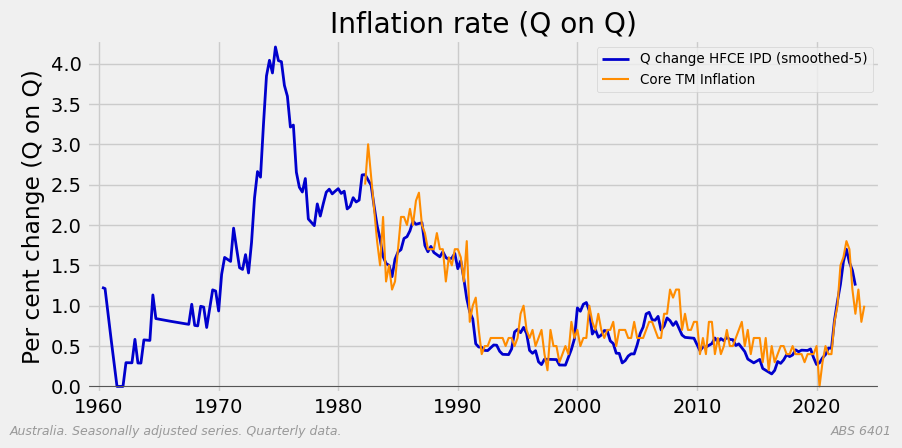

In [6]:
def get_ρ(measure="TM")-> tuple[pd.Series, pd.Series, pd.Series, pd.Series]:
    """Get the QonQ core inflation rate from the ABS, plus lagged rates.
    Arguments: Can choose between the trimmed mean (measure="TM") and the 
    weighted median (measure="WM").
    Returns: A tuple of four series - the core inflation rate, and that 
    rate lagged by 1, 2 and 3 quarters."""

    # Historic HFCE implicit price deflator - quarterly data
    hfce_meta, hfce = get_abs_series(cat_id="1364.0.15.003", series_ids=["A2454530W"])
    smooth = 5  # smoothing factor -- N periods -- must be odd
    delta_ipd = (
        hfce["A2454530W"]
        .rolling(window=smooth, min_periods=smooth, center=True).mean() # smooth the data
        .dropna()
        .pct_change()
        .mul(100.0)
        .dropna() # % change in implicit price deflator
    )

    # core inflation
    cpi_meta, cpi = get_abs_series(cat_id="6401.0", series_ids=["A3604510W", "A3604504A"])
    trimmed_mean = cpi["A3604510W"]  # preferred measure of core inflation
    weighted_median = cpi["A3604504A"]  # alternative measure of core inflation
    core = trimmed_mean if measure == "TM" else weighted_median
    delta_rho = core.dropna().sort_index()

    # plot the data
    plotting.line_plot(
        pd.DataFrame({f"Q change HFCE IPD (smoothed-{smooth})": delta_ipd, f"Core {measure} Inflation": delta_rho}),
        title=f"Inflation rate (Q on Q)", 
        ylabel="Per cent change (Q on Q)",
        lfooter="Australia. Seasonally adjusted series. Quarterly data. ", 
        rfooter="ABS 6401", 
        width=[2, 1.5],
        y0=True,
        show=SHOW, 
    )

    # combine with the HFCE data
    delta_rho = delta_rho.reindex(delta_ipd.index.union(delta_rho.index))
    delta_rho = delta_rho.where(delta_rho.notna(), other=delta_ipd).dropna().sort_index()
 
    # lagged core inflation
    delta_rho_1 = delta_rho.shift(periods=1).dropna()
    delta_rho_2 = delta_rho.shift(periods=2).dropna()
    delta_rho_3 = delta_rho.shift(periods=3).dropna()

    return delta_rho, delta_rho_1, delta_rho_2, delta_rho_3


Δρ, Δρ_1, Δρ_2, Δρ_3 = get_ρ()

#### Inflation expectations (synthetic data)

I have serious dobts about the generated synthetic data

/var/folders/96/8bhlz_x975z93glbxq_2_yqr0000gn/T/ipykernel_47592/340523535.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.read_csv("./NAIRU_INPUTS/PIE_RBAQ.CSV", index_col=0, parse_dates=True)


Missing values in bond yield:  PeriodIndex(['2013Q2'], dtype='period[Q-DEC]')


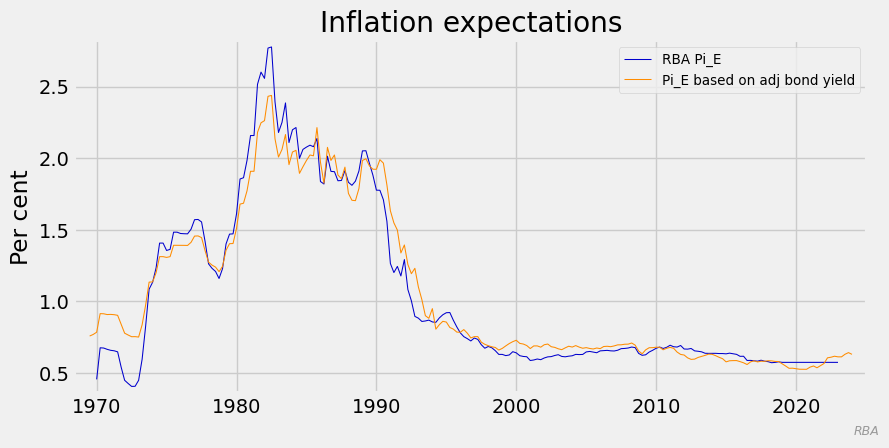

In [7]:
def get_πe()-> pd.Series:
    """Approximate inflation expectations from the RBA data.
    Theory here is that prior to inflation targeting in 1993, the
    10-year bond rate broadly reflected inflation expectations. After 1993, the 
    RBA's inflation target became the primary driver of inflation 
    expectations -- Note: this is all a bit rough and ready."""

    rba_pie = (
        # From RBA model - hard to replicate exactly
        pd.read_csv("./NAIRU_INPUTS/PIE_RBAQ.CSV", index_col=0, parse_dates=True)
        .to_period(freq="Q")
        .pipe(lambda x: x[x.columns[0]])
        .dropna()
    )

    # A very rough approximation of inflation expectations from the bond yield
    bond_yields = pd.read_excel(
        "./NAIRU_INPUTS/RBA_bonds.xls", index_col=0, parse_dates=True, skiprows=10
    )
    bond_yield = monthly_to_quarterly(bond_yields["FCMYGBAG10"])
    # There is a missing value in Q2 2013, so we will interpolate it
    new_by_index = pd.period_range(start=bond_yield.index[0], end=bond_yield.index[-1], freq="Q")
    bond_yield = bond_yield.reindex(new_by_index)
    print("Missing values in bond yield: ", bond_yield[bond_yield.isna()].index)
    bond_yield = bond_yield.interpolate(method="linear", limit_area="inside")
    
    pie = ((1 + bond_yield / 100) ** 4 - 1) * 3  # Roughly approximate RBA inflation expectations
    pie[pie.index > "1994Q1"] = pie/4 + 0.5
    plotting.line_plot(
        pd.DataFrame({"RBA Pi_E": rba_pie, "Pi_E based on adj bond yield": pie}),
        title="Inflation expectations",
        ylabel="Per cent",
        rfooter="RBA",
        show=SHOW,
    )

    # options to use RBA data where available
    #rba_pie = rba_pie.reindex(pie.index).sort_index()
    #return rba_pie.where(rba_pie.notnull(), other=pie) # use RBA data where available

    return pie 


Δρe = get_πe()


#### Import prices (from ABS 6457)

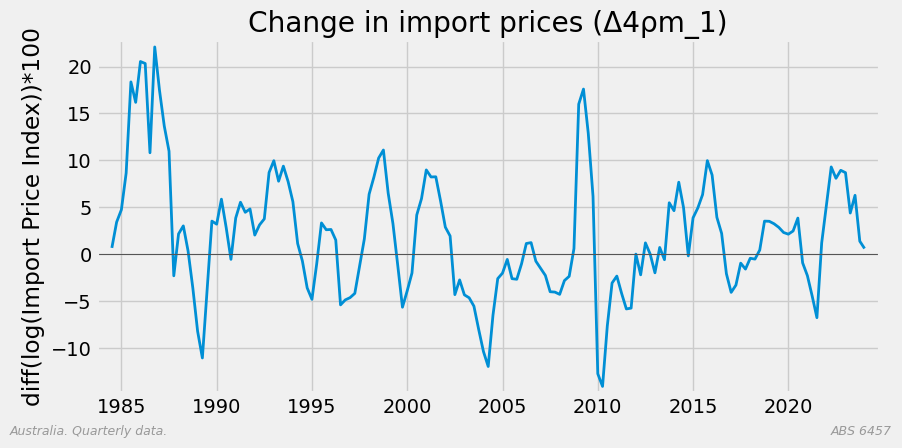

In [8]:
def get_import_pricing() -> tuple[pd.Series, pd.Series]:
    """Get the import pricing data from the ABS and calculate the
    change in import prices as a proportion of the import prices."""

    # Import Price Index by Balance of Payments, index, original
    trade_meta, trade = get_abs_series(cat_id="6457.0", series_ids=["A2298279F"])
    log_import_prices = trade["A2298279F"].apply(np.log)
    delta4_log_import_prices = log_import_prices.diff(periods=4).dropna() * 100
    Δ4ρm_1 = delta4_log_import_prices.shift(periods=1).dropna()
    Δ4ρm_2 = delta4_log_import_prices.shift(periods=2).dropna()

    # plot the data
    ax = Δ4ρm_1.plot(lw=2)
    plotting.finalise_plot(
        ax,
        title="Change in import prices (Δ4ρm_1)", 
        ylabel="diff(log(Import Price Index))*100",
        y0=True,
        lfooter="Australia. Quarterly data. ",
        rfooter="ABS 6457",
        show=SHOW,
    )

    return Δ4ρm_1, Δ4ρm_2  


Δ4ρm_1, Δ4ρm_2 = get_import_pricing()
    

#### Unit labour costs

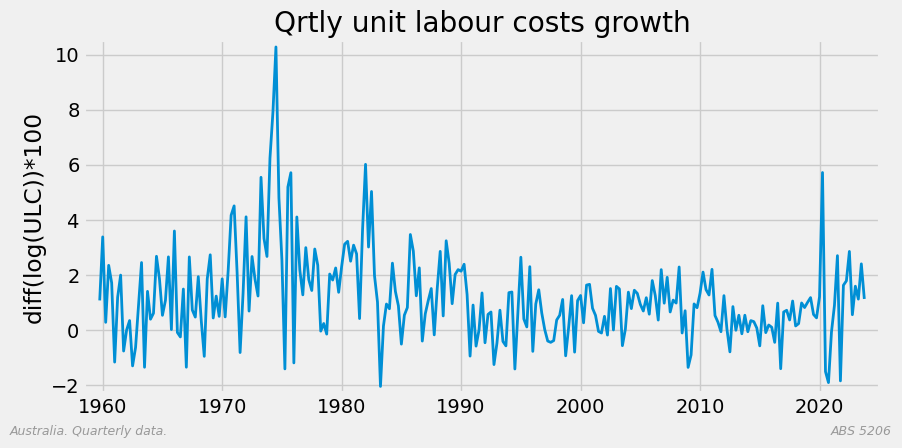

In [9]:

def get_ulc() -> pd.Series:
    """Quarterly unit labour costs growth."""

    nat_accounts_meta, nat_accounts = (
        get_abs_series(cat_id="5206.0", series_ids=["A2304402X", "A2302915V"])
    )
    ulc = nat_accounts["A2302915V"]/nat_accounts["A2304402X"]
    log_ulc = ulc.apply(np.log)
    delta_ulc = (log_ulc.diff(periods=1)).dropna() * 100

    # plot the data
    ax = delta_ulc.plot(lw=2)
    plotting.finalise_plot(
        ax,
        title="Qrtly unit labour costs growth",
        ylabel="diff(log(ULC))*100",
        lfooter="Australia. Quarterly data. ",
        rfooter="ABS 5206",
        show=SHOW,
    )
    return delta_ulc


Δulc = get_ulc()

#### Global supply constraints during COVID period

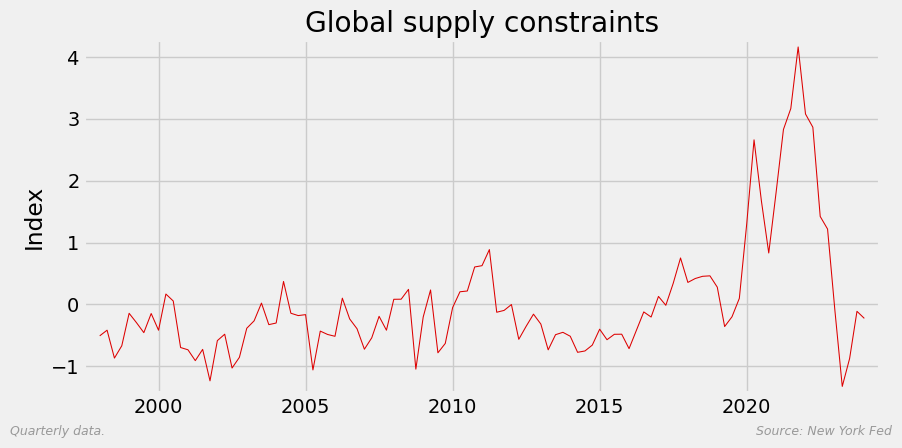

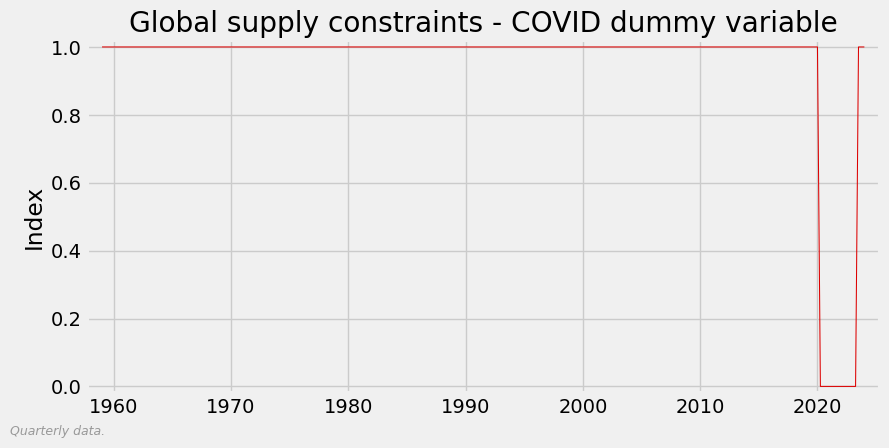

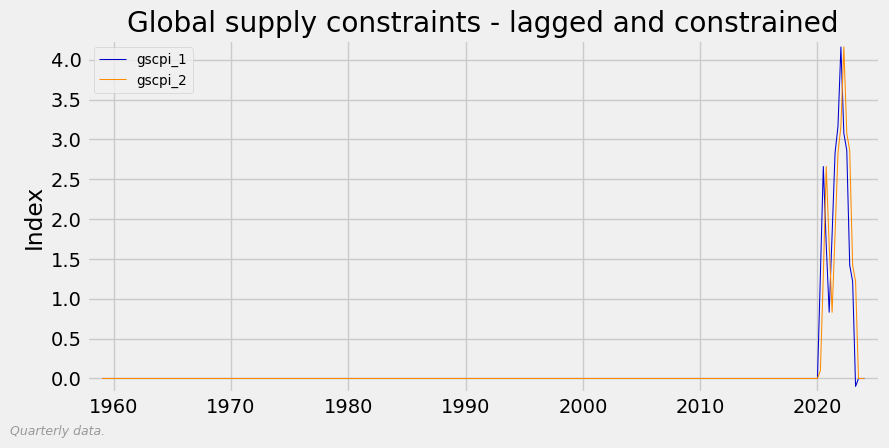

In [10]:
def get_gscpi() -> pd.Series:
    """Global Supply Chain Price Index. Usefulk for capturing global supply constraints
    associated with the COVID-19 pandemic (and subsequent reopening) and the Ukraine war.
    From: https://www.newyorkfed.org/research/policy/gscpi#/interactive"""

    gscpi = pd.read_excel(
        "./NAIRU_INPUTS/gscpi_data.xls", sheet_name="GSCPI Monthly Data", 
        index_col=0, parse_dates=True
    )["GSCPI"]
    gscpi = monthly_to_quarterly(gscpi)
    gscpi.index = pd.PeriodIndex(gscpi.index, freq="Q")
    gscpi_1 = gscpi.shift(periods=1).dropna()
    gscpi_2 = gscpi.shift(periods=2).dropna()
    dummy = pd.Series(1, pd.period_range(start="1959Q1", end=gscpi.index[-1], freq="Q"))
    dummy["2020Q2":"2023Q2"] = 0  # - key dates for COVID period
                                         
    plotting.line_plot(
        gscpi,
        title='Global supply constraints',
        ylabel="Index",
        lfooter="Quarterly data. ",
        rfooter="Source: New York Fed",
        show=SHOW,
    )

    plotting.line_plot(
        dummy,
        title='Global supply constraints - COVID dummy variable',
        ylabel="Index",
        lfooter="Quarterly data. ",
        show=SHOW,
    )
    # fix for COVID period
    gscpi_1 = gscpi_1.where(dummy == 0, other=0).reindex(dummy.index).fillna(0)
    gscpi_2 = gscpi_2.where(dummy == 0, other=0).reindex(dummy.index).fillna(0)

    plotting.line_plot(
        pd.DataFrame({"gscpi_1": gscpi_1, "gscpi_2": gscpi_2}),
        title='Global supply constraints - lagged and constrained',
        ylabel="Index",
        lfooter="Quarterly data. ",
        show=SHOW,
    )
    return dummy, gscpi_1, gscpi_2


ξ_dummy, ξ_1, ξ_2 = get_gscpi()

#### COVID-19 dummy variables


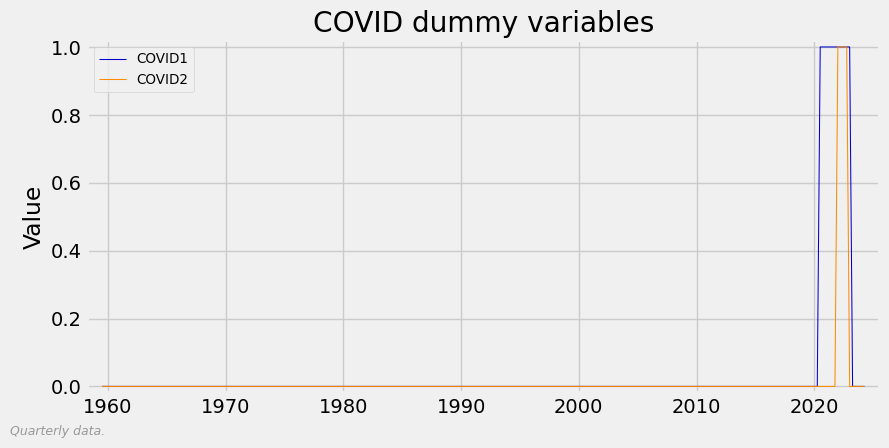

In [11]:
def get_covid_dummies() -> tuple[pd.Series, pd.Series]:
    """Get dummy variables for COVID disruptions.  Idea from Zax Gross."""

    covid1 = pd.Series(0, index=pd.period_range(start="1959Q3", end=pd.Timestamp("today").to_period(freq="Q")))
    covid1["2020Q3":"2023Q1"] = 1  # core problematic period
    covid2 = pd.Series(0, index=pd.period_range(start="1959Q3", end=pd.Timestamp("today").to_period(freq="Q")))
    covid2["2022Q1":"2022Q4"] = 1  # sholder problematic period

    data = pd.DataFrame({"COVID1": covid1, "COVID2": covid2})
    #display(data["2020Q1":"2023Q2"])
    plotting.line_plot(
        data,
        title='COVID dummy variables',
        ylabel="Value",
        lfooter="Quarterly data. ",
        show=SHOW,
    )

    return covid1, covid2

ξ_covid1, ξ_covid1 = get_covid_dummies() 

## Data wrangling

Make sure all the vectors are the same length, with no missing data, and in the correct vector format

In [12]:
def build_obs() -> dict[str, np.ndarray]:
    """Here, we standardise the length of all observations
    and place them into the obs dictionary, which is returned.
    Beacuse the PeriodIndex data has been removed from the
    "observations matrix", we also return the index separately."""

    observed = pd.DataFrame({

        # Note: in the process of model development, not all of the data
        # collected here will be used in the model. However, it is retained
        # as it may be useful in the future.

        "Δρ": Δρ,                       # core inflation
        "Δρ_1": Δρ_1,                   # lagged core inflation
        "Δρ_2": Δρ_2,
        "Δρ_3": Δρ_3, 
        "Δρe": Δρe,                     # inflation expectations

        "U": U,                         # unemployment rate
        "ΔU_1_over_U": ΔU_1_over_U,     # change in UE rate as a proportion of UE rate

        "Δ4ρm_1": Δ4ρm_1,               # annual change in import prices,
        "Δ4ρm_2": Δ4ρm_2,               # annual change in import prices, lagged 1 period

        "Δulc": Δulc,                   # unit labour costs growth

        # a range of markers for global supply constraints with/following COVID-19
        "ξ_covid1": ξ_covid1,           # dummy variable for COVID period
        "ξ_covid2": ξ_covid1,           # dummy variable for COVID period
        "ξ_dummy": ξ_dummy,             # dummy variable for the not-COVID period
        "ξ_1": ξ_1,                     # lagged supply shock 
        "ξ_2": ξ_2,                     # lagged supply shock
    })
    observed = observed.dropna(how="any")  # Note ulc comes from Nat Accounts, which is delayed data
    print(f"Number of periods: {len(observed)}; from: {observed.index[0]}, concluding: {observed.index[-1]}")

    return {x: y.to_numpy() for x, y in observed.items()}, observed.index


obs, obs_index = build_obs()

Number of periods: 157; from: 1984Q4, concluding: 2023Q4


## Bayesian model



#### The PyMC model

In [13]:
def inflation_equation(
    input: dict[str, np.ndarray], 
    model: pm.Model,
    nairu: pm.GaussianRandomWalk,
) -> None:
    """Inflation likelihood equation."""
    
    with model:
        # priors - comment out unused priors
        alpha_inf = pm.Normal("alpha_inf",   mu=0.1,  sigma=0.05)  # mport prices
        beta1_inf = pm.Normal("beta1_inf",   mu=0.4,  sigma=0.2)# lagged inflation
        beta2_inf = pm.Normal("beta2_inf",   mu=0.3,  sigma=0.2)
        beta3_inf = pm.Normal("beta3_inf",   mu=0.2,  sigma=0.2)
        gamma_inf = pm.Normal("gamma_inf",   mu=-0.3, sigma=1)  # unemployment gap
        delta_inf = pm.Normal("delta_inf",   mu=0,    sigma=1)  # inflation expectations i
        lambda_inf = pm.Normal("lambda_inf", mu=0,    sigma=1)  # UE rate change
        sigma_inf = pm.Normal("sigma_inf",   mu=0,    sigma=1)  # error term

        #xi_covid1_inf = pm.Normal("xi_covid1_inf", mu=0.5, sigma=1)  # COVID dummy variable
        #xi_covid2_inf = pm.Normal("xi_covid2_inf", mu=0.5, sigma=1)  # COVID dummy variable

        #xi_1_inf = pm.Normal("xi_1_inf", mu=0, sigma=1)         # lagged COVID supply shock
        #xi_2_inf = pm.Normal("xi_2_inf", mu=0, sigma=1)         # lagged COVID supply shock

        xi_1sq_inf = pm.Normal("xi_1sq_inf", mu=0, sigma=1)     # lagged COVID supply shock squared
        xi_2sq_inf = pm.Normal("xi_2sq_inf", mu=0, sigma=1)     # lagged COVID supply shock squared

        # const_inf = pm.Normal("const_inf", mu=0.0, sigma=10)    # constant

        # likelihood
        observed_price_inflation = pm.Normal(
            "observed_price_inflation",
            mu = 
            alpha_inf * (input["Δ4ρm_1"] - input["Δ4ρm_2"])     # mport prices
            + beta1_inf * input["Δρ_1"]                         # lagged inflation
            + beta2_inf * input["Δρ_2"] 
            + beta3_inf * input["Δρ_3"]
            + gamma_inf * (input["U"] - nairu)/input["U"]       # unemployment gap
            + delta_inf * input["Δρe"]                          # inflation expectations           
            + lambda_inf * input["ΔU_1_over_U"]                 # UE rate change

            #+ xi_covid1_inf * input["ξ_covid1"]                 # COVID dummy variable
            #+ xi_covid2_inf * input["ξ_covid2"]                 # COVID dummy variable
            
            #+ xi_1_inf * input["ξ_1"]                           # lagged COVID supply shock
            #+ xi_2_inf * input["ξ_2"]                           # lagged COVID supply shock

            + xi_1sq_inf * input["ξ_1"]**2 * np.sign(input["ξ_2"])  # lagged COVID supply shock squared, sign adjusted
            + xi_2sq_inf * input["ξ_2"]**2 * np.sign(input["ξ_2"])  # lagged COVID supply shock squared, sign adjusted

            #+ const_inf                                         # constant
            ,
            sigma=sigma_inf,
            observed=input["Δρ"],
        )

def wage_growth_equation(
    input: dict[str, np.ndarray],
    model: pm.Model,
    nairu: pm.GaussianRandomWalk
) -> None:
    """Wage growth likelihood equation."""

    with model:
        # priors
        beta_lab = pm.Normal("beta_lab", mu=0, sigma=1)         # lagged inflation
        gamma_lab = pm.Normal("gamma_lab", mu=0, sigma=1)       # unemployment gap
        delta_lab = pm.Normal("delta_lab", mu=0, sigma=1)       # inflation expectations
        lambda_lab = pm.Normal("lambda_lab", mu=0, sigma=5)     # UE rate change
        sigma_lab = pm.Normal("sigma_lab", mu=0, sigma=1)       # error term
        #const_lab = pm.Normal("const_lab", mu=0.0, sigma=10)    # constant

        # likelihood
        observed_wage_growth = pm.Normal(
            "observed_wage_growth",
            mu =
            beta_lab * (input["Δρ_1"] +  input["Δρ_2"])         # lagged inflation
            + gamma_lab * ((input["U"] - nairu)/input["U"])     # unemployment gap
            + delta_lab * input["Δρe"]                          # inflation expectations 
            + lambda_lab * input["ΔU_1_over_U"]                 # UE rate change
            #+ const_lab                                         # constant  
            ,
            sigma=sigma_lab,
            observed=input["Δulc"],
        )

def nairu_equation(input: dict[str, np.ndarray], model) -> pm.GaussianRandomWalk:
    """Gaussian random walk for the NAIRU."""

    with model:
        # priors
        nairu_start = pm.Normal.dist(mu=7, sigma=2)
        nairu_innovation = 0.2  # fixed/constrained innovation for now
        nairu = pm.GaussianRandomWalk(
            "nairu",
            mu=0,  # no drift in this model
            sigma=nairu_innovation,
            init_dist=nairu_start,
            steps=len(input["U"])-1,
        )

    return nairu


def define_model(input: dict[str, np.ndarray]) -> pm.Model:
    """Define the model for the NAIRU estimation."""

    model = pm.Model()

    nairu = nairu_equation(input, model)
    inflation_equation(input, model, nairu)
    wage_growth_equation(input, model, nairu)  

    return model


model = define_model(input=obs)

#### Generate a map of the model

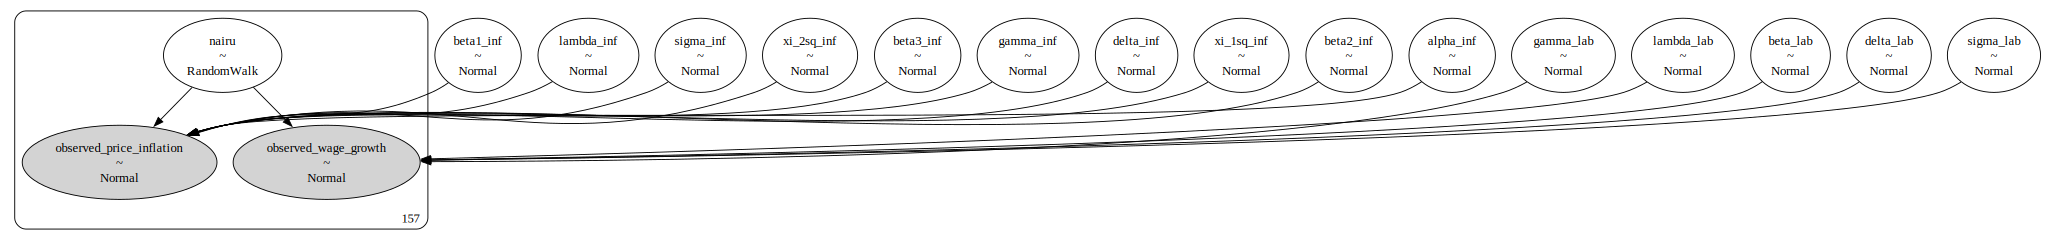

In [14]:
def produce_model_map(m: pm.Model) -> None:
    """Produce a map of the model."""
    
    gv = pm.model_to_graphviz(m)
    gv.render(
        format="png",
        filename=("./NAIRU_INPUTS/nairu model"),
    )
    display(gv)


produce_model_map(model)

#### Fit the model to the data

Note: sometimes the fitting starts with a stack of divergences. The best thing is to discard that run and re-run the model. 

This does not happen often, but it does suggest the model needs to be reparameterised a little.

In [15]:
N_CORES: int = 8
SAMPLES: int = 100_000
SAMPLES_PER_CORE: int = int(SAMPLES / N_CORES)
TUNE: int = 5_000  # per chain

SAMPLE_ARGS = {
    "draws": SAMPLES_PER_CORE,
    "tune": TUNE,
    "cores": N_CORES,
    "chains": N_CORES,
    "nuts_sampler": "numpyro",
}

  0%|          | 0/17500 [00:00<?, ?it/s]

  0%|          | 0/17500 [00:00<?, ?it/s]

  0%|          | 0/17500 [00:00<?, ?it/s]

  0%|          | 0/17500 [00:00<?, ?it/s]

  0%|          | 0/17500 [00:00<?, ?it/s]

  0%|          | 0/17500 [00:00<?, ?it/s]

  0%|          | 0/17500 [00:00<?, ?it/s]

  0%|          | 0/17500 [00:00<?, ?it/s]

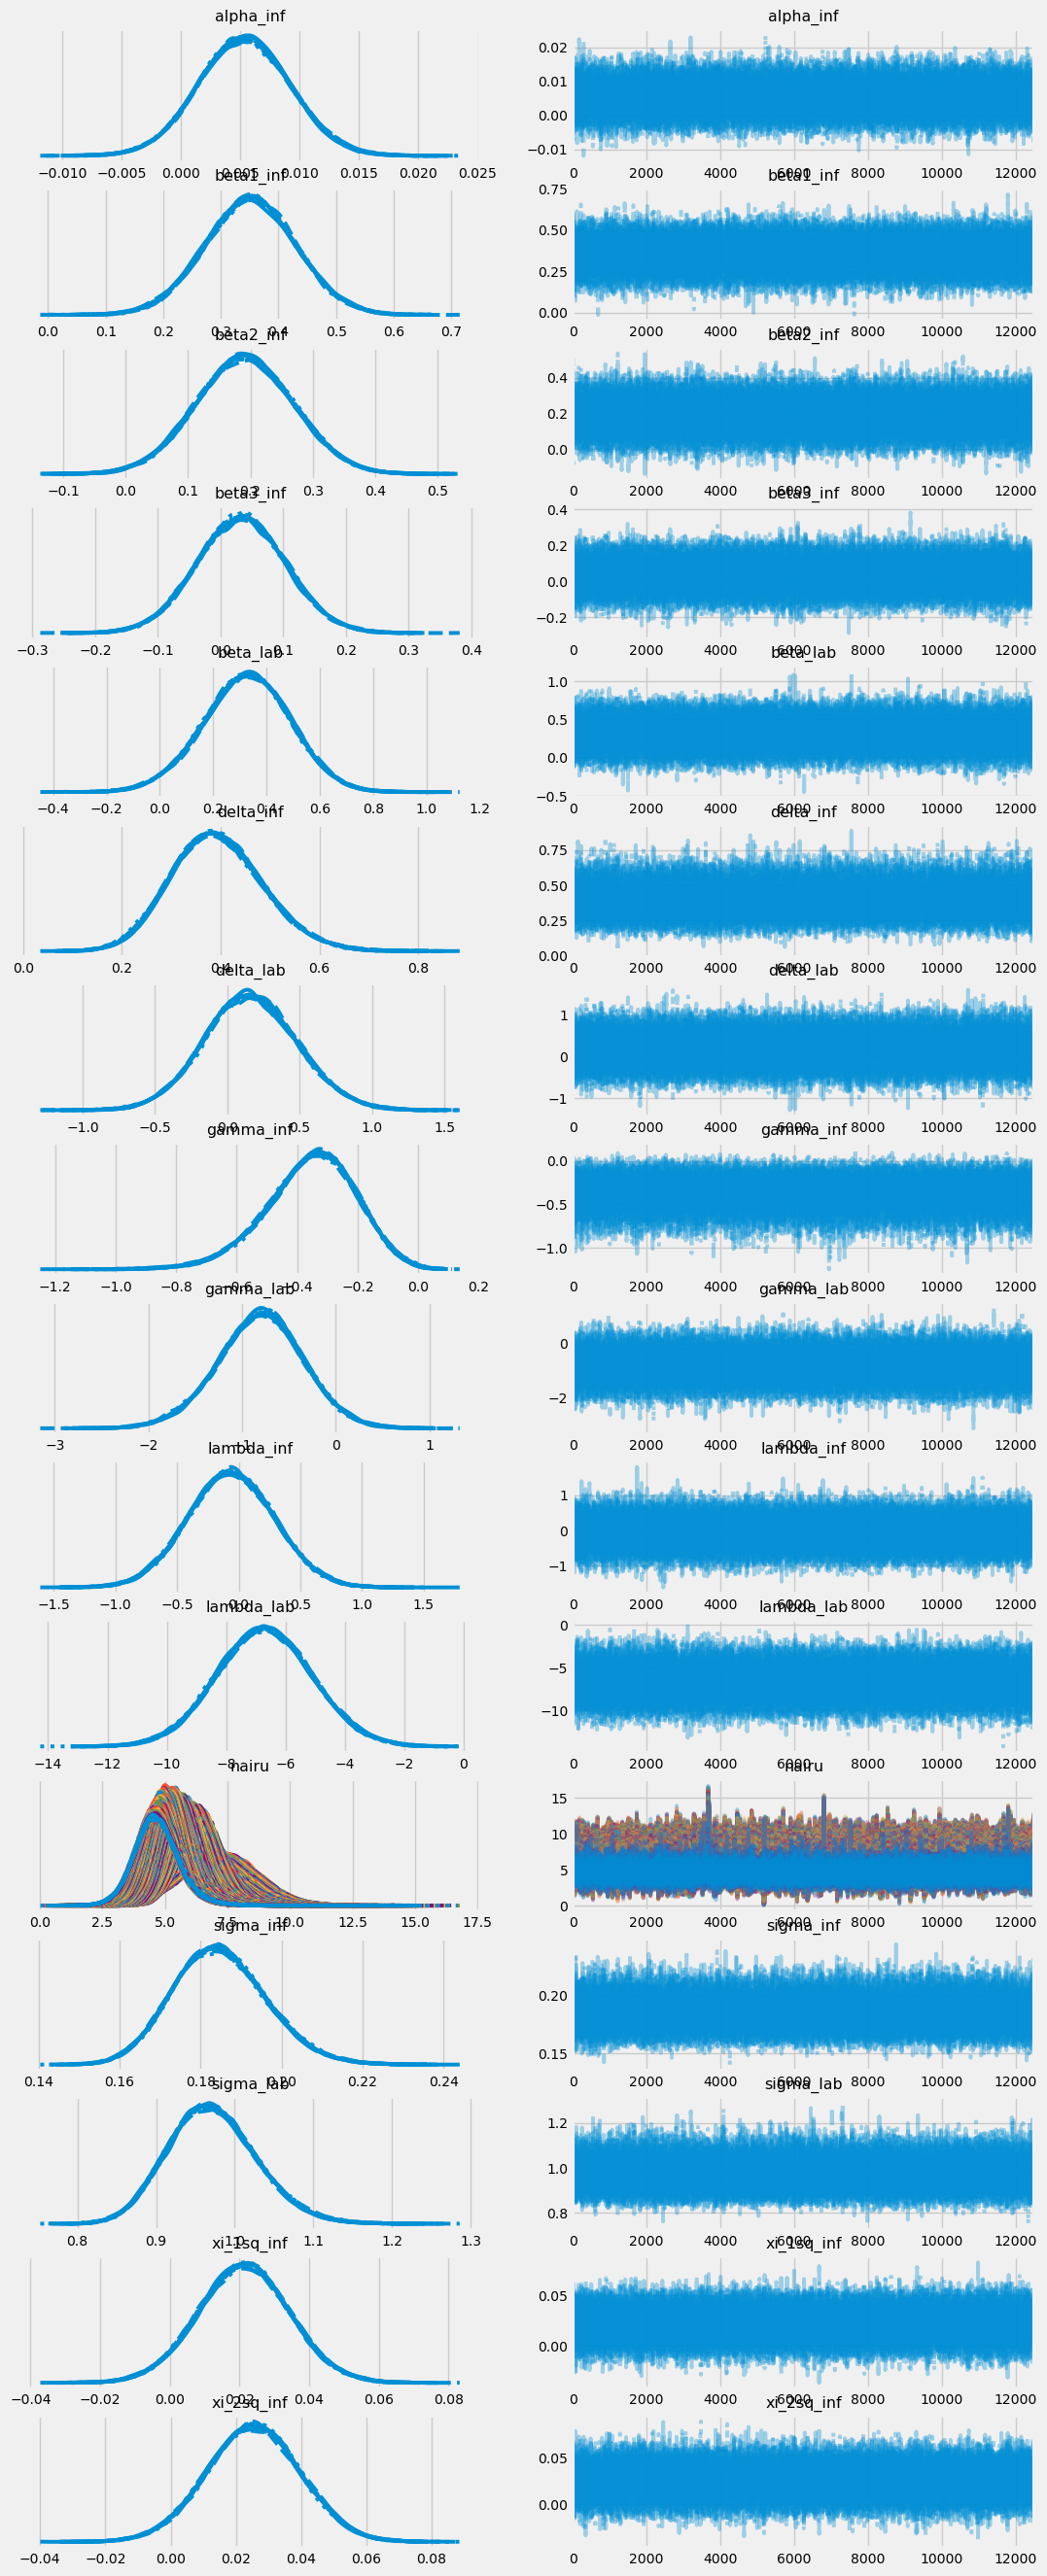

In [16]:
def fit_the_model(model: pm.Model) -> az.InferenceData:
    """Fit the data to the model."""
    
    with model:
        idata = pm.sample(
            **SAMPLE_ARGS,
            progressbar=True,
            return_inferencedata=True,
        )
        az.plot_trace(idata)
    return idata


trace = fit_the_model(model)

## Check diagnostics

In [17]:
def check_trace(trace: az.InferenceData) -> None:
    """Check the trace for potential problems."""

    def warn(w: bool) -> str:
        return '--- THERE BE DRAGONS ---> ' if w else ''
    
    summary = az.summary(trace)

    max_r_hat = 1.01  # Best result is 1.0
    statistic = summary.r_hat.max()
    print(f"{warn(statistic > max_r_hat)}Maximum R-hat convergence diagnostic: {statistic}")

    min_ess = 400  # best if the minimum effective sample size is > 1000
    statistic = summary[["ess_tail", "ess_bulk"]].min().min()
    print(f"{warn(statistic < min_ess)}Minimum effective sample size (ESS) estimate: {statistic}")

    # We don't want any divergences in the posterior sampling process
    try:
        diverging_count = int(np.sum(trace.sample_stats.diverging))
    except (ValueError, AttributeError):  # No sample_stats, or no .diverging
        diverging_count = 0
    print(f"{warn(diverging_count > 0)}Divergent transitions in HMC sampling: {diverging_count}")  


check_trace(trace)

Maximum R-hat convergence diagnostic: 1.0
Minimum effective sample size (ESS) estimate: 9078.0
Divergent transitions in HMC sampling: 0


## Results

In [18]:
def get_var(var_name: str, trace: az.InferenceData) -> pd.DataFrame:
    """Extract the chains/draws for a specified var_name."""

    return (
        az.extract(trace, var_names=var_name)
        .transpose("sample", ...)
        .to_dataframe()[var_name]
        .unstack(level=2)
        .T
    )

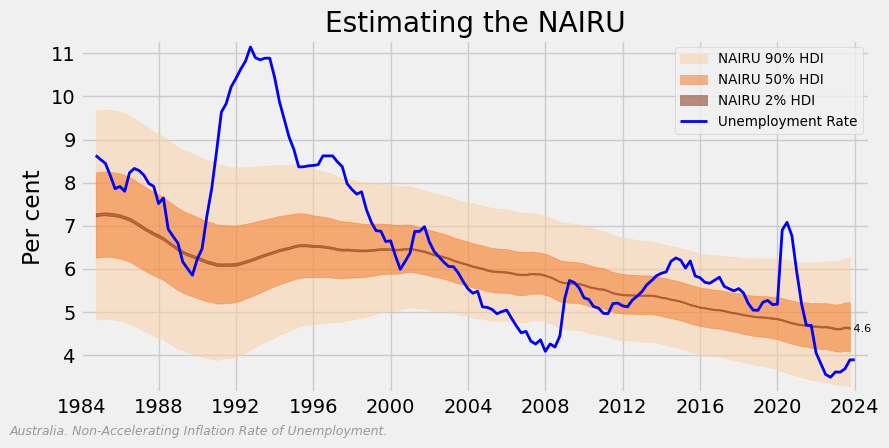

In [19]:
def plot_nairu(
    trace: az.InferenceData,
    obs: dict[str, np.ndarray],
    obs_index: pd.PeriodIndex,
) -> None:
    """Plot the NAIRU."""

    nairu = get_var("nairu", trace)
    nairu.index = obs_index.to_timestamp()
    PERCENTS = [5, 25, 49]
    _COLORS = [(p - min(PERCENTS)) / (max(PERCENTS) - min(PERCENTS)) for p in PERCENTS]
    MIN_COLOR = 0.25
    COLOR_FRACS = [c * (1.0 - MIN_COLOR) + MIN_COLOR for c in _COLORS]
    palette = "Oranges"
    _, ax = plt.subplots()
    cmap = plt.get_cmap(palette)

    for i, p in enumerate(PERCENTS):
        quants = p, 100 - p
        label = f"NAIRU {quants[1] - quants[0]}% HDI"
        lower, upper = [nairu.quantile(q=q / 100.0, axis=1) for q in quants]
        color = COLOR_FRACS[i]
        ax.fill_between(
            nairu.index,
            upper,
            lower,
            color=cmap(color),
            alpha=0.5,
            label=label,
            zorder=i + 1,
        )
    Uplot = U[U.index >= obs_index[0]]
    ax.plot(
        Uplot.index.to_timestamp(),
        Uplot,
        color="blue",
        lw=2,
        label="Unemployment Rate",
        zorder=10,
    )
    latest = round(nairu.iloc[-1].quantile(0.5), 1)
    ax.text(nairu.index[-1], latest, f" {latest}", va="center", ha="left", color="black", fontsize=8)
    plotting.finalise_plot(
        ax,
        title="Estimating the NAIRU",
        ylabel="Per cent",
        legend={"loc": "upper right", "fontsize": "x-small"},
        lfooter="Australia. Non-Accelerating Inflation Rate of Unemployment.",
        show=True,
    )


plot_nairu(trace, obs, obs_index)

In [20]:
def print_parameter_summary() -> None:
    """Print the summary results of the model,
       useful for non-vector free variables in the model.
       Also indicates where parameters may be indistinguisable from zero,
       (ie. they are not significant within the model)."""

    # Calculate median and Highest Debsity Intervals (HDI) for the model parameters
    q = [0.02, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.98]  
    print(f"{(q[-1] - q[0]) * 100:0.0f}% HDI for the univariate model parameters:")
    results = {str(name): (
        az.extract(trace, var_names=str(name))
        .to_dataframe()[str(name)]
        .quantile(q)) for name in model.free_RVs
        if str(name) not in ["nairu"]
    }

    # Identify when the HDI includes zero, 
    # which might be a sign of a problematic parameter in a regression-like equation.
    # Give more stars the closer zero is to the median value;
    # I would want to think about the parameters with 2 or more stars.
    df = pd.DataFrame(results).T.sort_index()
    problem_intensity = (
        # how many stars to give: 0=great, 1=okay, 2+=parameter not significant
        pd.DataFrame(np.sign(df.T))
        .apply([lambda x: x.lt(0).sum(), lambda x: x.gt(0).sum()] )
        .min()
        .astype(int)
    )
    marker = pd.Series(['*'] * len(problem_intensity), index=problem_intensity.index)
    markers = marker.str.repeat(problem_intensity).reindex(problem_intensity.index).fillna('')
    df['Check Significance'] = markers

    # display results
    display(df)


print_parameter_summary()

96% HDI for the univariate model parameters:


,0.02,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.98,Check Significance
alpha_inf,-0.002553,-0.000961,0.000425,0.002719,0.005322,0.007926,0.010274,0.011680,0.013292,**
beta1_inf,0.188356,0.220944,0.250001,0.298099,0.351017,0.403825,0.451940,0.480467,0.514053,
beta2_inf,0.031258,0.063208,0.091572,0.138715,0.190650,0.243476,0.291244,0.318833,0.350000,
beta3_inf,-0.111593,-0.082453,-0.057233,-0.014494,0.033026,0.080291,0.122908,0.149135,0.178703,****
beta_lab,-0.016642,0.051818,0.114512,0.217205,0.327584,0.436125,0.532450,0.590507,0.654919,*
delta_inf,0.215210,0.247941,0.277523,0.328717,0.389489,0.453933,0.515337,0.554465,0.599470,
delta_lab,-0.485109,-0.357383,-0.242347,-0.054323,0.156878,0.376487,0.579179,0.703352,0.843616,****
gamma_inf,-0.693380,-0.617007,-0.550661,-0.447768,-0.345013,-0.251431,-0.171929,-0.127355,-0.079541,
gamma_lab,-1.788389,-1.578972,-1.396510,-1.105097,-0.796251,-0.498465,-0.223946,-0.056935,0.135745,*
lambda_inf,-0.773852,-0.635314,-0.506725,-0.297144,-0.063577,0.173956,0.388049,0.514724,0.662143,****
